## Imports

In [1]:
print('test')

test


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.table import Table
import os

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

In [3]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [4]:
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(co_map)
import extinction as ex

In [5]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [30]:
import icemodels
imp.reload(icemodels)
from icemodels.core import optical_constants_cache_dir, read_ocdb_file, download_all_ocdb, composition_to_molweight
from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, load_molecule_ocdb, atmo_model, molecule_data
from icemodels.gaussian_model_components import co_ice_wls_icm, co_ice_wls, co_ice_widths, co_ice_bandstrength
from astroquery.svo_fps import SvoFps
from astropy import table
co_ice_wls, co_ice_widths


(<Quantity [4.66483183, 4.67311557, 4.68055231] um>,
 <Quantity [0.0065282 , 0.0076433 , 0.02322202] um>)

# Exploring Other Ices

In [7]:
filter_data = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data.add_index('filterID')
flxd = filter_data['filterID']
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

## Opacities

In [111]:
lis = co_map.list_consts_files('_CO_', verbose=True)

63_CO_(1)_25K_Gerakines.txt
75_CO_1_762_45.0K.txt
61_CO_1_548_15.0K.txt
75_CO_1_760_35.0K.txt
75_CO_1_761_40.0K.txt
43_CO_(1)_12K_Elsila.txt
61_CO_1_555_35.0K.txt
267_CO_(1)_15K_Palumbo.txt
61_CO_1_553_28.0K.txt
61_CO_1_549_18.0K.txt
75_CO_1_754_15.0K.txt
85_CO_(1)_10K_Hudgins.txt
61_CO_1_552_25.0K.txt
269_CO_(1)_15K_Palumbo.txt
34_CO_(1)_10K_Ehrenfreund.txt
75_CO_1_758_25.0K.txt
75_CO_1_759_30.0K.txt
64_CO_(1)_25K_Gerakines.txt
35_CO_(1)_30K_Ehrenfreund.txt
75_CO_1_756_20.0K.txt
1_CO_(1)_12.5K_Baratta.txt
61_CO_1_554_30.0K.txt
61_CO_1_550_20.0K.txt
75_CO_1_757_22.0K.txt
75_CO_1_755_18.0K.txt
61_CO_1_551_22.5K.txt


Text(0.5, 1.0, 'CO')

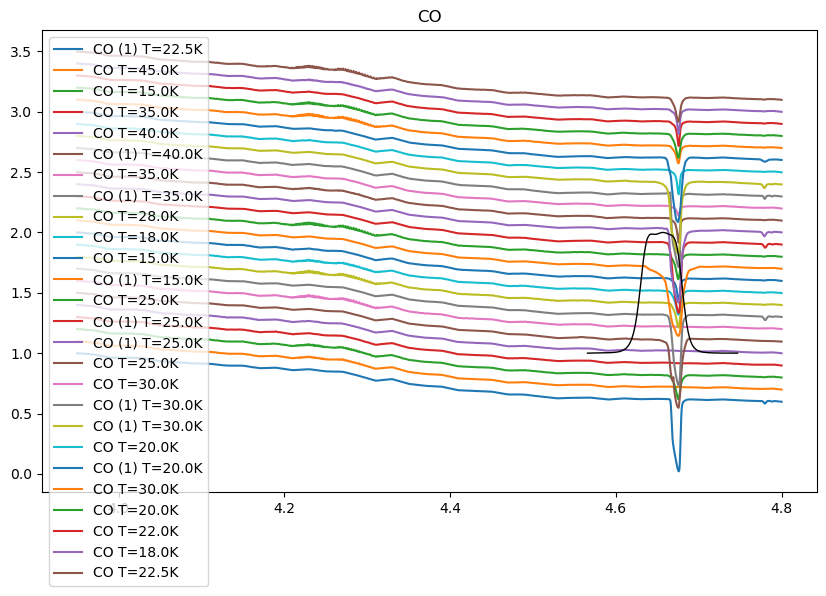

In [124]:
#consts_file = lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'
figure = plt.figure(figsize=(10, 6))
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
i=0
for consts_file in lis:
    try: 
        consts = read_ocdb_file(f'{consts_file}')
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
        consts.meta['composition'] = 'CO'
        
    molwt = composition_to_molweight('CO')*u.Da

    aspec = absorbed_spectrum(1e18*u.cm**-2, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
    plt.plot(xarr.to(u.um), aspec / aspec.max()+i, label=f'{consts.meta['composition']} T={label}')
    i += 0.1
plt.legend()

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=1,
        color='k')
plt.title('CO')

Text(0.5, 1.0, '63_CO_(1)_25K_Gerakines.txt')

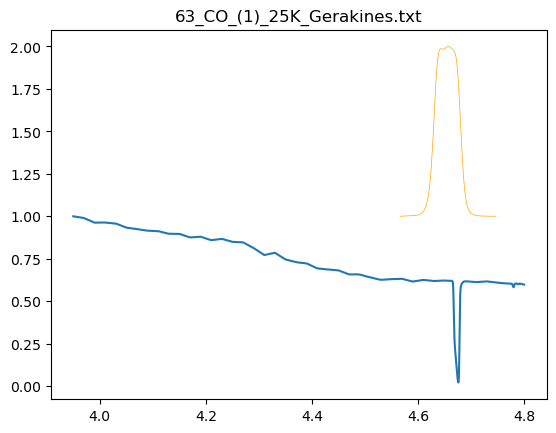

In [ ]:
consts_file = lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'

filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
consts = read_ocdb_file(f'{optical_constants_cache_dir}/{consts_file}')
molwt = composition_to_molweight(consts.meta['composition'])*u.Da

aspec = absorbed_spectrum(1e18*u.cm**-2, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
plt.plot(xarr.to(u.um), aspec / aspec.max())

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')
plt.title(consts_file)

In [16]:
lis = co_map.list_consts_files('OCN', verbose=True)

158_OCN-_1_1172_12.0K.txt
158_OCN-_1_1143_80.0K.txt


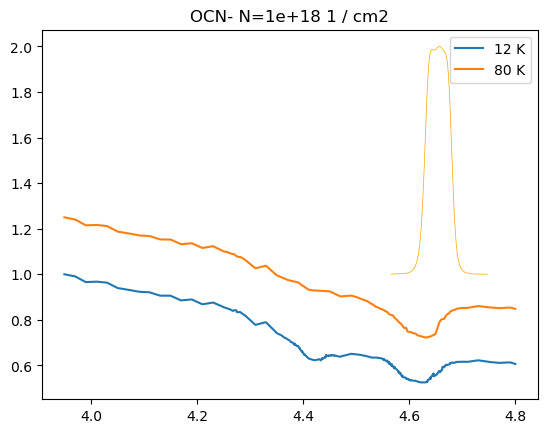

In [105]:
N_OCN = 1e18*u.cm**-2

consts_file = '158_OCN-_1_1172_12.0K.txt' #lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'

filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
#consts = read_ocdb_file(f'{optical_constants_cache_dir}/{consts_file}')
consts = Table.read(f'{optical_constants_cache_dir}/{consts_file}', format='ascii')
consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
consts.rename_column('col2', 'k')
consts.meta['density'] = 1.0 * u.g / u.cm**3
molwt = composition_to_molweight('OCN')*u.Da

aspec = absorbed_spectrum(N_OCN, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
plt.plot(xarr.to(u.um), aspec / aspec.max(), label='12 K')

consts_file = '158_OCN-_1_1143_80.0K.txt'
consts = Table.read(f'{optical_constants_cache_dir}/{consts_file}', format='ascii')
consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
consts.rename_column('col2', 'k')
consts.meta['density'] = 1.0 * u.g / u.cm**3
molwt = composition_to_molweight('OCN')*u.Da

aspec = absorbed_spectrum(N_OCN, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
plt.plot(xarr.to(u.um), aspec / aspec.max() + 0.25, label='80 K')

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')

#filterid = 'JWST/NIRCam.F410M'
#trans = SvoFps.get_transmission_data(filterid)
#plt.plot(trans['Wavelength'].quantity.to(u.um),
#        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
#        linewidth=0.5,
#        color='orange')
#
#filterid = 'JWST/NIRCam.F405N'
#trans = SvoFps.get_transmission_data(filterid)
#plt.plot(trans['Wavelength'].quantity.to(u.um),
#        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
#        linewidth=0.5,
#        color='orange')
plt.title(f'OCN- N={N_OCN}')
plt.legend()

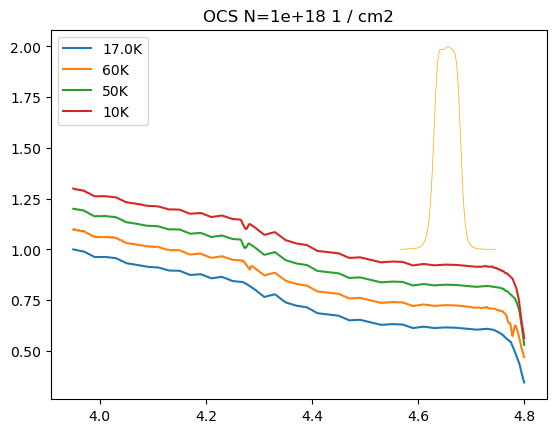

In [110]:
lis = co_map.list_consts_files('_OCS_', verbose=False)

N_OCS = 1e18*u.cm**-2

filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)
i = 0.0

for consts_file in lis: 
    try: 
        consts = read_ocdb_file(f'{consts_file}')
        label = consts_file.split('/')[-1].split('_')[-2]
    except:
        consts = Table.read(f'{consts_file}', format='ascii')
        consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
        consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
        consts.rename_column('col2', 'k')
        consts.meta['density'] = 1.0 * u.g / u.cm**3
        label = consts_file.split('/')[-1].split('_')[-1][:-4]
    molwt = composition_to_molweight('OCS')*u.Da

    aspec = absorbed_spectrum(N_OCS, consts, spectrum=phx4000['fnu'], xarr=xarr, molecular_weight=molwt)
    
    plt.plot(xarr.to(u.um), aspec / aspec.max()+i, label=label)
    i += 0.1

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')
plt.title(f'OCS N={N_OCS}')
plt.legend()

## Column Densities

In [11]:
consts_file = '158_OCN-_1_1172_12.0K.txt' #lis[0].split('/')[-1] #'22_HCN (1)_95K_Dello.txt'

filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
phx4000 = atmo_model(4000, xarr=xarr)
#consts = read_ocdb_file(f'{optical_constants_cache_dir}/{consts_file}')
consts = Table.read(f'{optical_constants_cache_dir}/{consts_file}', format='ascii')
consts.rename_column('col1', 'Wavenumber (cm⁻¹)_1')
consts['Wavelength'] = 1e4 / consts['Wavenumber (cm⁻¹)_1'] * u.um
consts.rename_column('col2', 'k')
consts.meta['density'] = 1.0 * u.g / u.cm**3
molwt = composition_to_molweight('OCN')*u.Da
#1_CO_(1)_12.5K_Baratta.txt')#
#consts = load_molecule_ocdb(molecule) # OCDB = optical constants database
# phx4000 = stellar atmosphere model spectrum at 4000K
xarr = phx4000['nu'].quantity.to(u.um, u.spectral())
# column densities of CO ice
cols = np.geomspace(1e15, 1e20, 25)
dmags410 = []
dmags466 = []

print(f"  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466")
for col in cols:
    # for each column density of CO (ice?), make a spectrum of it 
    # absorbed_spectrum takes spectrum and puts the effects of an absorption feature in front of it 
    spec = absorbed_spectrum(col*u.cm**-2, consts, molecular_weight=molwt,
                              spectrum=phx4000['fnu'].quantity, # flux array
                              xarr=xarr, # wavelength array
                             )
    cmd_x = ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')
    flxd_ref = fluxes_in_filters(xarr, phx4000['fnu'].quantity)
    flxd = fluxes_in_filters(xarr, spec)
    # the star's magnitude
    mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                   -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
    # the magnitude of the star with the CO ice
    #mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
    mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
              -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
    # the difference in magnitudes in F410M and F466N
    dmags466.append(mags_x[1]-mags_x_star[1])
    dmags410.append(mags_x[0]-mags_x_star[0])
    # why would f410m change at all?
    print(f"{col:8.1g}, {mags_x[0]:8.1f}, {mags_x_star[0]:8.1f}, {mags_x[1]:8.1f}, {mags_x_star[1]:8.1f}, {dmags410[-1]:8.1f}, {dmags466[-1]:8.1f}")

  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466
   1e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   2e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   3e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   4e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   7e+15,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   1e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   2e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   3e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   5e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   7e+16,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   1e+17,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   2e+17,    -13.7,    -13.7,    -14.0,    -14.0,      0.0,      0.0
   3e+17,    -13.6,    -13.7,    -14.0,    -14.0,      0.1,      0.0
   5e+17,    -13.6,    -13.7,    -13

Text(0.5, 1.0, '158_OCN-_1_1172_12.0K.txt')

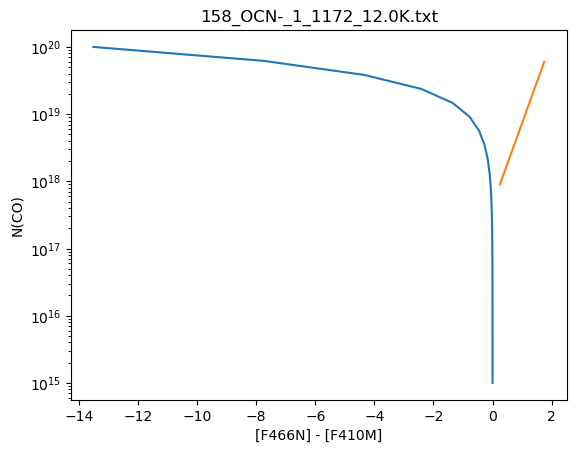

In [12]:
dmag_466m410 = np.array(dmags466) - np.array(dmags410) 
plt.semilogy(dmag_466m410[cols<1e21], cols[cols<1e21])
plt.xlabel('[F466N] - [F410M]')
plt.ylabel('N(CO)')
plt.plot([0.25, 1.75], [9e17, 6e19]);
plt.title(os.path.basename(os.path.normpath(consts_file)))

In [13]:
composition_to_molweight('SiO')*u.Da

<Quantity 44.084905 u>